In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

from orbit.utils.stan import get_compiled_stan_model_simplified, compile_stan_model_simplified
from orbit.utils.dataset import load_iclaims
import arviz as az

In [2]:
ss_model_path = "../stan/ss_local_level_boxcox.stan"
compiled_path = compile_stan_model_simplified(ss_model_path)
ss_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

Revisit the m3 data for debug purpose.

In [3]:
# raw_data = load_iclaims()
# raw_y = raw_data['claims']
# y = raw_y / np.mean(raw_y)
# sdy = np.std(y)

Run the `load_data` first after downloading the data from kaggle m5 homepage.

In [5]:
raw_data = pd.read_csv("../../m5_study/clean/response_df.csv")

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3,d,date
0,0,0,0,0,0,0,0,12,2,0,...,1,0,4,0,0,0,0,0,d_1,2011-01-29
1,0,0,0,0,0,0,0,15,0,0,...,1,0,4,0,0,6,0,0,d_2,2011-01-30
2,0,0,0,0,0,0,0,0,7,1,...,1,0,2,2,0,0,0,0,d_3,2011-01-31
3,0,0,0,0,0,0,0,0,3,0,...,1,0,5,2,0,2,0,0,d_4,2011-02-01
4,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,2,0,0,d_5,2011-02-02


In [18]:
raw_y = raw_data['FOODS_3_822_WI_3'].values
normalizer_y = max(np.mean(raw_y), 0.1)
y = raw_y / normalizer_y
sdy = np.std(y)

In [9]:
data = {
    'N': len(y),
    'Y' : y,
    'SD_Y' : sdy,
    'A1' : 0.0,
    'P1' : 0.0,
    'STATE_SIGMA_MEAN': 1.0,
    'STATE_SIGMA_SD': 1.0,
    'OBS_SIGMA_MEAN': 1.0,
    'OBS_SIGMA_SD': 1.0,
}

In [10]:
ss_fit = ss_mod.sampling(
    data=data,
    warmup=1000,
    iter=1100,
    chains=4,
)


Gradient evaluation took 0.000638 seconds

Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 6.38 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000623 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.23 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000503 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.03 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  220 / 1100 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


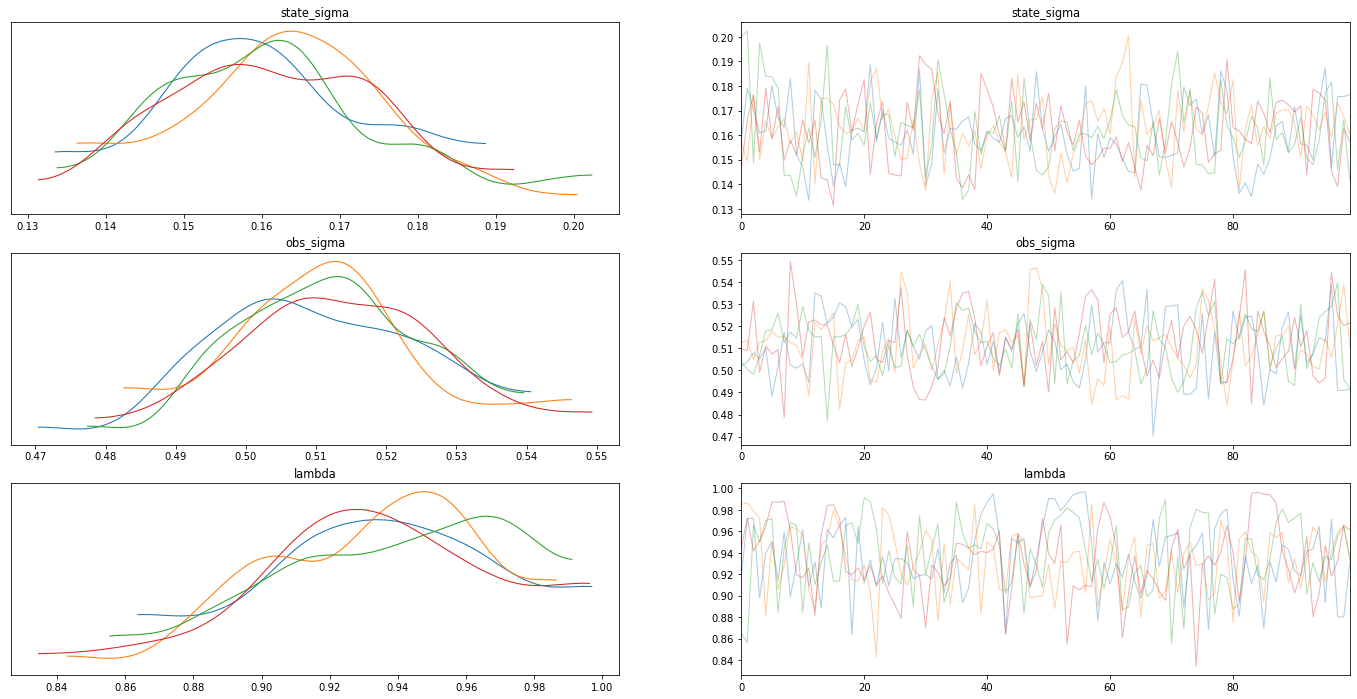

In [11]:
az_posteriors = az.from_pystan(ss_fit)
az.plot_trace(az_posteriors, var_names=['state_sigma', 'obs_sigma', 'lambda'], compact=False, figsize=(24, 12));

In [12]:
ss_posteriors = ss_fit.extract(pars=['state_sigma', 'states', 'obs_sigma', 'lambda'], permuted=True)
lambda_ = np.expand_dims(ss_posteriors['lambda'], -1)
states = ss_posteriors['states']

In [13]:
yhat = np.power(1 + lambda_ * states, 1 / lambda_)[:, :-1] * np.mean(raw_y)
yhat_upper, yhat_med, yhat_lower = np.quantile(yhat, q=[0.9, 0.5, 0.1], axis=0)

In [14]:
yhat

array([[3.15404431, 3.39608746, 3.58480242, ..., 2.14758218, 2.34072967,
        2.47563762],
       [3.15404431, 3.38764771, 3.56835081, ..., 2.1218642 , 2.31530305,
        2.44964363],
       [3.15404431, 3.39069702, 3.54733673, ..., 2.09783158, 2.36792039,
        2.55656366],
       ...,
       [3.15404431, 3.38556977, 3.57375625, ..., 2.13561974, 2.29802027,
        2.41069235],
       [3.15404431, 3.40425782, 3.59547797, ..., 2.16387999, 2.37266576,
        2.51933486],
       [3.15404431, 3.38799891, 3.56610073, ..., 2.11802142, 2.32056021,
        2.46127888]])

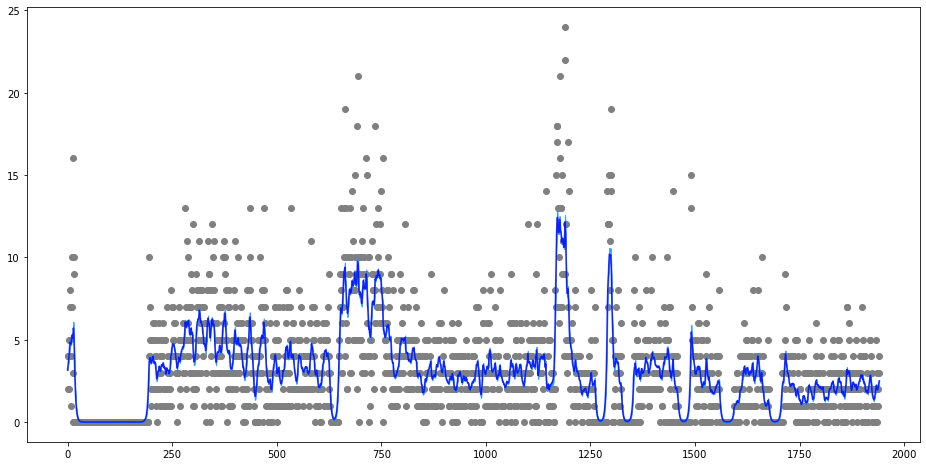

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, raw_y, c='grey')
ax.plot(x, yhat_med, color='blue', alpha=0.8);
ax.fill_between(x=x, y1=yhat_lower, y2=yhat_upper, color='dodgerblue', alpha=0.8);

In [11]:
ss_posteriors = ss_fit.extract(pars=['F'])
ss_posteriors['F'].mean()

0.2122981230111735